In [ ]:
!pip install torch torchvision matplotlib seaborn scikit-learn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
#Load Data

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.82MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.06MB/s]


In [ ]:
# Define AE

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat.view(-1, 1, 28, 28), z


Using device: cpu
Epoch 1, Loss: 0.2468
Epoch 2, Loss: 0.2138
Epoch 3, Loss: 0.2074
Epoch 4, Loss: 0.2035
Epoch 5, Loss: 0.2005
Epoch 6, Loss: 0.1983
Epoch 7, Loss: 0.1966
Epoch 8, Loss: 0.1953
Epoch 9, Loss: 0.1941
Epoch 10, Loss: 0.1932


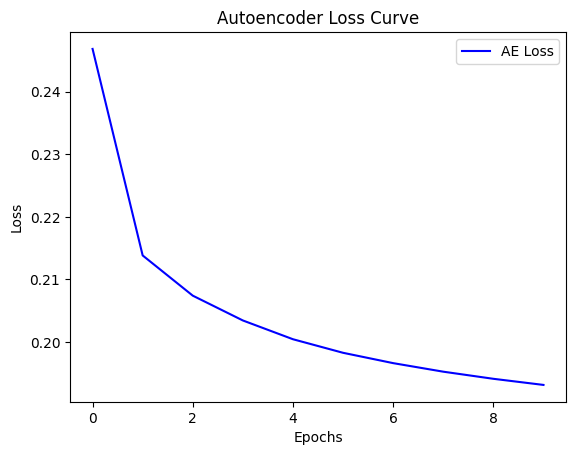

In [ ]:
# Train AE and Plot Loss curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

ae = Autoencoder().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
ae_losses = []

for epoch in range(10):
    total_loss = 0
    ae.train()
    for x, _ in train_loader:
        x = x.to(device)
        x_hat, _ = ae(x)
        loss = criterion(x_hat, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    ae_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Plot AE loss curve
plt.plot(ae_losses, label='AE Loss', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Autoencoder Loss Curve")
plt.legend()
plt.savefig("loss_curve_ae.png")
plt.show()



In [ ]:
# Define VAE

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc_mu = nn.Linear(128, 2)
        self.fc_logvar = nn.Linear(128, 2)
        self.fc3 = nn.Linear(2, 128)
        self.fc4 = nn.Linear(128, 784)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h)).view(-1, 1, 28, 28)

    def forward(self, x):
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar, z


Using device: cpu
Epoch 1, Loss: 208.1150
Epoch 2, Loss: 176.2406
Epoch 3, Loss: 169.2513
Epoch 4, Loss: 166.3386
Epoch 5, Loss: 164.5902
Epoch 6, Loss: 163.2472
Epoch 7, Loss: 162.1081
Epoch 8, Loss: 161.0782
Epoch 9, Loss: 160.1603
Epoch 10, Loss: 159.3328


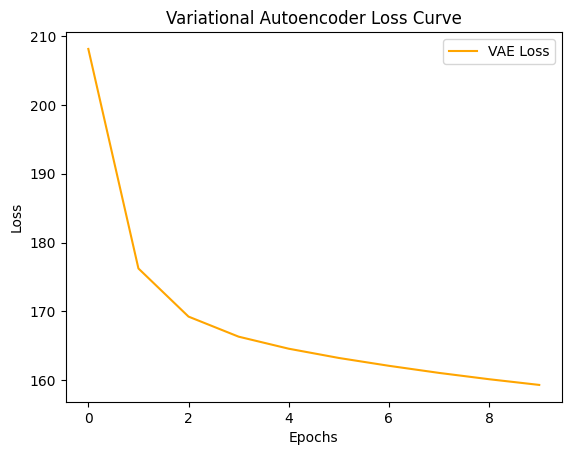

In [21]:
# Train VAE and Plot Loss Curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
vae_losses = []

def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (BCE + KLD) / x.size(0)

for epoch in range(10):
    total_loss = 0
    vae.train()
    for x, _ in train_loader:
        x = x.to(device)
        recon, mu, logvar, _ = vae(x)
        loss = loss_fn(recon, x, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    vae_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Plot VAE loss curve
plt.plot(vae_losses, label='VAE Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Variational Autoencoder Loss Curve")
plt.legend()
plt.savefig("loss_curve_vae.png")
plt.show()




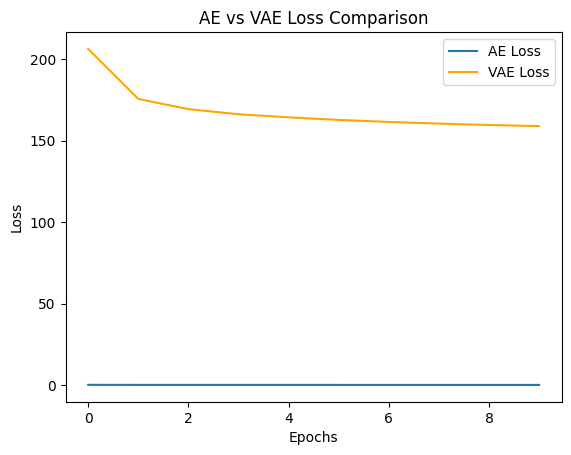

In [ ]:
# Combined AE and VAE Loss curve

plt.plot(ae_losses, label='AE Loss')
plt.plot(vae_losses, label='VAE Loss', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("AE vs VAE Loss Comparison")
plt.legend()
plt.savefig("combined_loss_curve.png")
plt.show()


Using device: cpu


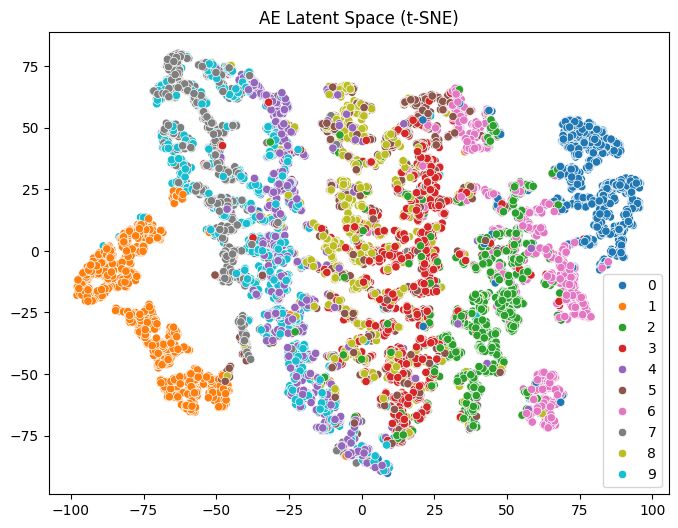

In [ ]:
# AE Latent Space Visualization (t-SNE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

ae.eval()
all_z_ae = []
all_labels_ae = []

with torch.no_grad():
    for x, labels in test_loader:
        x = x.to(device)
        _, z = ae(x)
        all_z_ae.append(z.cpu())
        all_labels_ae.append(labels)

z_all_ae = torch.cat(all_z_ae).numpy()
labels_all_ae = torch.cat(all_labels_ae).numpy()

tsne_ae = TSNE(n_components=2, random_state=0)
z_tsne_ae = tsne_ae.fit_transform(z_all_ae)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=z_tsne_ae[:, 0], y=z_tsne_ae[:, 1], hue=labels_all_ae, palette="tab10", legend="full")
plt.title("AE Latent Space (t-SNE)")
plt.savefig("latent_ae_tsne.png")
plt.show()



Using device: cpu


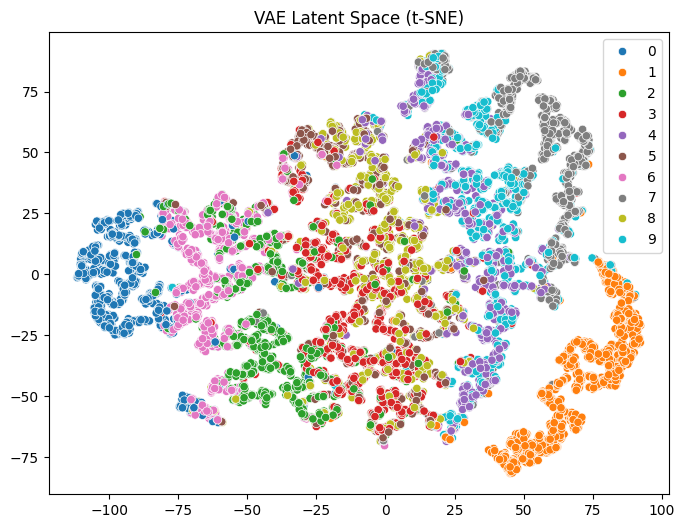

In [ ]:
# VAE Latent Space Visualization (t-SNE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

vae.eval()
all_z_vae = []
all_labels_vae = []

with torch.no_grad():
    for x, labels in test_loader:
        x = x.to(device)
        _, _, _, z = vae(x)
        all_z_vae.append(z.cpu())
        all_labels_vae.append(labels)

z_all_vae = torch.cat(all_z_vae).numpy()
labels_all_vae = torch.cat(all_labels_vae).numpy()

tsne_vae = TSNE(n_components=2, random_state=0)
z_tsne_vae = tsne_vae.fit_transform(z_all_vae)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=z_tsne_vae[:, 0], y=z_tsne_vae[:, 1], hue=labels_all_vae, palette="tab10", legend="full")
plt.title("VAE Latent Space (t-SNE)")
plt.savefig("latent_vae_tsne.png")
plt.show()



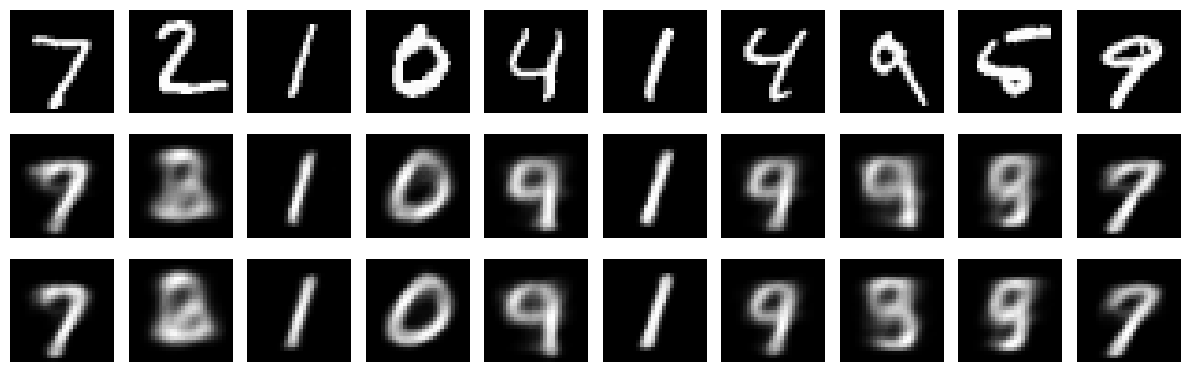

In [ ]:
# AE and VAE Reconstruction Comparison

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get 10 sample images
images, _ = next(iter(test_loader))
images = images[:10].to(device)

# AE Reconstruction
with torch.no_grad():
    recon_ae, _ = ae(images)

# VAE Reconstruction
with torch.no_grad():
    recon_vae, _, _, _ = vae(images)

# Plot original, AE, and VAE reconstructions
plt.figure(figsize=(12, 4))
for i in range(10):
    # Original
    plt.subplot(3, 10, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("Original", fontsize=10)

    # AE
    plt.subplot(3, 10, 10 + i + 1)
    plt.imshow(recon_ae[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("AE", fontsize=10)

    # VAE
    plt.subplot(3, 10, 20 + i + 1)
    plt.imshow(recon_vae[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.ylabel("VAE", fontsize=10)

plt.tight_layout()
plt.savefig("reconstruction_comparison.png")
plt.show()



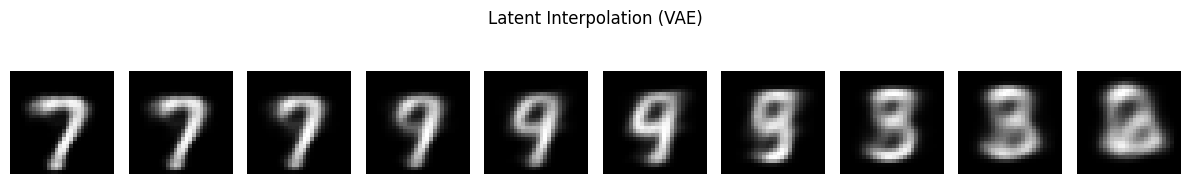

In [ ]:
# Latent Vector Interpolation (VAE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae.to(device)
vae.eval()

# Function to interpolate between two latent vectors
def interpolate(z1, z2, steps=10):
    return torch.stack([z1 * (1 - t) + z2 * t for t in torch.linspace(0, 1, steps)])

# Get two test images
images, _ = next(iter(test_loader))
x1, x2 = images[0].to(device), images[1].to(device)

# Encode to latent vectors and interpolate
with torch.no_grad():
    _, _, _, z1 = vae(x1.unsqueeze(0))
    _, _, _, z2 = vae(x2.unsqueeze(0))
    z_interp = interpolate(z1, z2, steps=10).to(device)
    x_interp = vae.decode(z_interp)

# Plot interpolated images
plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_interp[i].cpu().squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Latent Interpolation (VAE)", fontsize=12)
plt.tight_layout()
plt.savefig("latent_interpolation.png")
plt.show()

